[View in Colaboratory](https://colab.research.google.com/github/sentientc/stemlab-notebooks/blob/master/cmaq_setup_notes.ipynb)

In [1]:
import glob
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.collections import PolyCollection
import matplotlib.ticker as ticker
import matplotlib as mpl
from scipy.io import netcdf
from IPython.display import display
import sys
sys.path.insert(0,'/wrk/simon/scripts/python/functions/')
from read_smk import read_dat,get_speciate,get_tprof,read_inv,get_abbr,get_scc
from matlab_functions import ismember,fdainb
from aermod import plottw,plotboarders
from read_model import cmaq_time,read_cmaq,cmaq_map
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"
%matplotlib inline
tscc=get_scc('39130','VOC')

/archives/utils/SMOKE/data/inventory/teds9/point/tscc.pkl loaded


##### WEBFIRE species from SCC in YUNLIN

In [ ]:
dfile='/archives/data/speciate/WebFIREFactors_090716.csv'
df=pd.read_csv(dfile)
wscc=(df['SCC'].map(np.str_)).values
wpol=df['POLLUTANT'].values

In [ ]:
ia,ib=ismember(wscc,tscc)
wpol=np.unique(wpol[ia])
wscc=np.unique(wscc[ia])
print(wpol)

['1,1,1-Trichloroethane' '1,2,3,4,6,7,8-Heptachlorodibenzo-p-dioxin'
 '1,2,3,4,6,7,8-Heptachlorodibenzofuran'
 '1,2,3,4,7,8,9-Heptachlorodibenzofuran'
 '1,2,3,4,7,8-Hexachlorodibenzo-p-dioxin'
 '1,2,3,4,7,8-Hexachlorodibenzofuran'
 '1,2,3,6,7,8-Hexachlorodibenzo-p-dioxin'
 '1,2,3,6,7,8-Hexachlorodibenzofuran'
 '1,2,3,7,8,9-Hexachlorodibenzo-p-dioxin'
 '1,2,3,7,8,9-Hexachlorodibenzofuran'
 '1,2,3,7,8-Pentachlorodibenzo-p-dioxin'
 '1,2,3,7,8-Pentachlorodibenzofuran' '1,3-Butadiene'
 '2,3,4,6,7,8-Hexachlorodibenzofuran' '2,3,4,7,8-Pentachlorodibenzofuran'
 '2,3,7,8-Tetrachlorodibenzo-p-dioxin' '2,3,7,8-Tetrachlorodibenzofuran'
 '2,4-Dinitrotoluene' '2-Chloroacetophenone' '2-Methyl Naphthalene'
 '3-Methylcholanthrene' '5-Methyl Chrysene' 'Acenaphthene' 'Acenaphthylene'
 'Acetaldehyde' 'Acetonitrile' 'Acetophenone' 'Acrolein' 'Aluminum'
 'Ammonia' 'Anthracene' 'Antimony' 'Arsenic' 'Barium' 'Benzene'
 'Benzo (a) anthracene' 'Benzo (a) pyrene' 'Benzo (b) fluoranthene'
 'Benzo (g,h,i) perylene

In [ ]:
print(f'USEPA WEBFIRE emission factor database has {len(wpol)} pollutants matched to the {len(wscc)} SCC in YUNLIN.')

USEPA WEBFIRE emission factor database has 156 pollutants matched to the 48 SCC in YUNLIN.


# CMAQ inputs

## 1. Emissions 
美國環保署(USEPA)依其排放源分類碼(SCC)建立個排放源汙染物排放因子(emission factor)WEBFIRE資料庫(USEPA, 2014)。SMOKE模式再依此關係將總有機汙染物解析(speciation)成各種CMAQ模式中大氣化學反應中模擬的汙染物。SMOKE模式又依SCC分類加入排放源時程，使各排放源排放依每日作息而有其日變化，周變化及月變化週期。

TEDS9.0以2013排放量為基準因無各行業成長率目前以2013排放量為2014排放量輸入SMOKE。TEDS9.0各點源均有相對應之SCC，但資料庫中面源及線源卻無SCC對應。SMOKE排放模擬以TEDS9.0面源及線源分類中最接近的SCC取代。另外部分TEDS9.0點源SCC無對應汙染物解析方法亦以最接近取代。日，周，及月變化週期目前以臺灣時區(GMT+8)輸入SMOKE模式並設定輸出時區為格林威治標準時間(GMT)與CMAQ模式同步。TEDS9.0面源及線源為網格化資料以逸散性點源輸入SMOKE模式
### 1.1 TEDS9.0 to SMOKE
(see cmaq_pre_emission.ipynb and cmaq_ddm_3d_yulin0.csh for actual code)    
  - TEDS9.0 is emission inventory of 2013 and is appled as 2014 emission inventory. May consider applying parameters such as GDP growth to test if the simulated emission is a better fit for the real world scenario.
  - TEDS9.0 area and line source NSC converted to EPA SCC(Source classification codes) and treated as point source fugitive emission
  - pollutant species: PM10, PM2.5, NOX, SOX, VOC, THC, CO, Pb, NH3(all records are 0)
  - pollutant speciated according to SCC (USEPA, 2014). 
  - SCC not found in the CB06 speciation scheme (USEPA, 2014) replaced with closest match. may consider construct speciation scheme from WEBFIRE database to include more species.
  - emission time zone is GMT+8 and SMOKE output as GMT
  - temporal profile assigned according to SCC(USEPA, 2017)  
  

##### TEDS9.0 area and line source classification to SCC

In [ ]:
keyf='/archives/data/tw/teds9/area_scc.xlsx'
indf=pd.read_excel(keyf,dtype=np.str)
display(indf.head(5))

,NSC,NSC_SUB,DESC,SCC
0,1,nan,住宅燃燒排放-液化石油氣,2104007000
1,5,nan,住宅燃燒排放-天然氣,2104006000
2,7,nan,商業燃燒排放,2103007000
3,7,A,商業燃燒排放-液化石油氣,2103007000
4,7,B,餐飲業油煙排放-中式餐飲,2103005000


##### TEDS9.0 SCC to USEPA SCC

In [ ]:
tdf=pd.read_fwf('/archives/utils/SMOKE/data/ge_dat/scc0_cb6.txt',width=np.zeros(2)+10,index_col=False,names=['scc0','scc1'])
print(tdf.head(5))

       scc0      scc1
0  10200210  10200205
1  28888802  30799999
2  30102112  30102113
3  30103425  30107001
4  30103510  30101430


#### Pollutant speciation example 
 - SCC 30107001: fugitive leak of Industrial Processes - Chemical Manufacturing, source profile 95325 emit TOG with the following species ACET, ALD2, ALDX, BENZENE, CH4, ETH, ETHA, ETHY, and so on. note that SCC 30107001 is an industry average calculated by USEPA. There is no corresponding measurement in Taiwan so the profile 95325 is the "best guess" adopted.     

In [ ]:
ddir1=''.join(['/archives/utils/SMOKE/data/ge_dat/'])
dfile=''.join([ddir1,'gspro.cmaq_cb06.txt'])
scc1='30107001'
grp=get_speciate(dfile,scc1,'TOG')

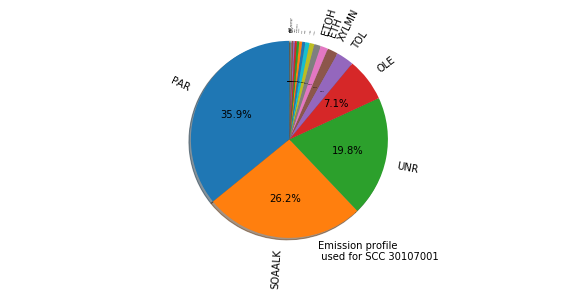

In [ ]:
labels=grp['pol'].values
sizes=grp['ratio'].values
srti=np.argsort(sizes)
sizes=sizes[srti][::-1]
labels=labels[srti][::-1]
fig,ax=plt.subplots()
#fig.set_figheight(10)
fig.set_figwidth(10)
pats,txts,auts=ax.pie(sizes,labels=labels,autopct='%1.1f%%',
        shadow=True,startangle=90,rotatelabels=True)
ax.axis('equal')
ax.text(0.55,0.04,''.join(['Emission profile\n used for SCC ',scc1]),verticalalignment='top', horizontalalignment='left',\
                    transform=ax.transAxes)
ax.set_aspect('equal', 'datalim')
list(map(lambda x:x.set_fontsize(2),auts[4:]))
list(map(lambda x:x.set_fontsize(2),txts[8:]))

In [ ]:
ddir1=''.join(['/archives/utils/SMOKE/data/ge_dat/'])
dfile=''.join([ddir1,'gspro.cmaq_cb06.txt'])
grp=get_speciate(dfile,tscc,'TOG')
pol=grp['pol'].values
pol=np.unique(pol)

In [ ]:
spc1,spc2=get_abbr()
ia,ib=ismember(pol,spc1)
def spc_match(x,spc2=spc2):    
    if np.isnan(x):
        xo='nomatch'
    else:
        xo=spc2[int(x)]
    return xo
spc3=list(map(spc_match,ib))

##### model species name speciated from VOC according to CB06 speciation

In [ ]:
#model species name
print(pol)

['ACET' 'ALD2' 'ALD2_PRIMARY' 'ALDX' 'BENZENE' 'CH4' 'ETH' 'ETHA' 'ETHY'
 'ETOH' 'FORM' 'FORM_PRIMARY' 'IOLE' 'ISOP' 'KET' 'MEOH' 'NAPH' 'NVOL'
 'OLE' 'PAR' 'PRPA' 'SOAALK' 'TERP' 'TOL' 'UNR' 'XYLMN']


##### Full species name(some are lumped into other species so not all name is correct)

In [ ]:
#full species name(some are lumped into other species so not all name is correct)
print(spc3)
print(len(spc3))

['ACETONE', 'ACETALDEHYDE', 'nomatch', 'GENERIC_ALDEHYDE', 'BENZENE', 'nomatch', 'ETHENE', 'ETHANE', 'ACETYLENE', 'ETHANOL', 'FORMALDEHYDE', 'nomatch', 'ETHENE', 'ISOPRENE', 'MEK', 'METHANOL', 'O-XYLENE', 'nomatch', 'ETHENE', 'ETHANE', 'PROPANE', 'DECANE', 'PINENE', 'TOLUENE', 'nomatch', 'O-XYLENE']
26


##### All pollutant species emitted from YUNLIN according CB06 speciation

In [ ]:
ddir1=''.join(['/archives/utils/SMOKE/data/ge_dat/'])
dfile=''.join([ddir1,'gspro.cmaq_cb06.txt'])
grp=get_speciate(dfile,tscc,'')
pol=grp['pol'].values
pol=np.unique(pol)
print(pol)
print(len(pol))

['ACET' 'ACETONITRILE' 'ACROLEIN' 'ACRYLICACID' 'ACRYLONITRILE' 'ALD2'
 'ALD2_PRIMARY' 'ALDX' 'BENZENE' 'BR2_C2_12' 'BUTADIE' 'BUTADIENE13'
 'CARBONTET' 'CARBSULFIDE' 'CH4' 'CHCL3' 'CHLOROPRENE' 'CL2' 'CL2_C2_12'
 'CL2_ME' 'CL3_ETHE' 'CL4_ETHANE1122' 'CL4_ETHE' 'CL_ETHE' 'CO' 'CUMENE'
 'DICHLOROBENZENE' 'DICHLOROPROPENE' 'DICHLRBNZN' 'DIESEL_PMC'
 'DIESEL_PMEC' 'DIESEL_PMFINE' 'DIESEL_PMNO3' 'DIESEL_PMOC' 'DIESEL_PMSO4'
 'ETH' 'ETHA' 'ETHDIBROM' 'ETHY' 'ETHYLBENZ' 'ETHYLBENZENE' 'ETOH' 'ETOX'
 'FORM' 'FORM_PRIMARY' 'HCL' 'HEXAMETHY_DIIS' 'HEXANE' 'HFLUX' 'HGIIGAS'
 'HGNRVA' 'HONO' 'HYDRAZINE' 'IOLE' 'ISOP' 'KET' 'MAL_ANHYDRIDE' 'MECL'
 'MEOH' 'METHCHLORIDE' 'NAPH' 'NH3' 'NH3_FERT' 'NO' 'NO2' 'NR' 'NVOL' 'OLE'
 'PAH_000E0' 'PAH_101E2' 'PAH_114E1' 'PAH_176E2' 'PAH_176E3' 'PAH_176E4'
 'PAH_176E5' 'PAH_192E3' 'PAH_880E5' 'PAL' 'PAR' 'PCA' 'PCL' 'PEC' 'PFE'
 'PH2O' 'PHGI' 'PK' 'PMG' 'PMN' 'PMOTHR' 'PNA' 'PNCOM' 'PNH4' 'PNO3' 'POC'
 'PROPDICHLORIDE' 'PROPDICLR' 'PRPA' 'PSI' 'PSO4' 'PTI' 'QUI

#### Stack temporal profile examples 
 - SCC 30107001 have a temporal profile of equal emission  
 - SCC 30501107 Cement Unloading to Elevated Storage Silo, have a temporal profile of diurnal pattern  
 - SCC 30900204 Garnet abrasive of diurnal pattern with 1 day off

In [ ]:
times=pd.date_range('2014-01-01','2014-01-16',freq='1H')
scc2='30501107'
scc3='30900204'
yemis=1e6
tprof1=get_tprof(times,scc1,yemis)
tprof2=get_tprof(times,scc2,yemis)
tprof3=get_tprof(times,scc3,yemis)

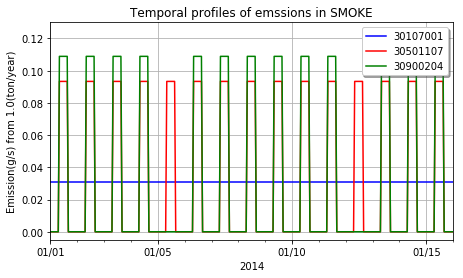

In [ ]:
fig,ax=plt.subplots()
#fig.set_figheight(10)
fig.set_figwidth(20)
ax.set_aspect(60,adjustable='box')
days5=mpl.dates.DayLocator([1,5,10,15])
days1=mpl.dates.DayLocator()
#hours1=mpl.dates.HourLocator(6)
tfmt=mpl.dates.DateFormatter('%m/%d')
ax.plot(times,tprof1,'-',color='b',label=scc1)
ax.plot(times,tprof2,'-',color='r',label=scc2)
ax.plot(times,tprof3,'-',color='g',label=scc3)
ax.axis([min(times),max(times),-0.005,0.13])
ax.xaxis.set_major_locator(days5)
ax.xaxis.set_minor_locator(days1)
#ax.xaxis.set_minor_locator(hours1)
ax.xaxis.set_major_formatter(tfmt)
legend=ax.legend(loc='upper right',shadow=True,markerscale=2)
ax.grid()
plt.xlabel(str(times[-1].year))
plt.ylabel(''.join(['Emission(g/s) from ',str(yemis/1e6),'(ton/year)']))
plt.title('Temporal profiles of emssions in SMOKE')

### 1.2 Industrial park specific emissions
see cmaq_pre_emission.ipynb and cmaq_ddm_3d_yulin.csh(all in one) and cmaq_ddm_3d_STK.csh(12 source groups) for actual code  
  - Input data: 2015 project emission profile of 16 species from 63 stacks
  - Each stack matched to TEDS9.0 entries in Yunlin with partial match in company name and select the stack with lowest height as worst case to import into SMOKE.
  - the 16 species added as inventory species and converted into appropraite species after speciation.

In [ ]:
dfile='/archives/data/tw/teds9/emissionLoc.xlsx'
dfe=pd.read_excel(dfile,dtype=np.str,sheetname='Y2014',names=['factory','shp','VINYCHLRI','BUTADIE','PROPDICLR','BENZENE','TRICLA112','MECL','TTCLE1122','ETHDIBROM','CHCL3','CARBONTET','CL2_C2_12','ETHYLBENZ','STYRENE','CUMENE','ISOP','DICHLRBNZN','key'])

display(dfe.head(5))
#with pd.option_context('display.max_rows',-1,'display.max_columns',5,'display.max_colwidth',-1):
#   display(dfe)

,factory,shp,VINYCHLRI,BUTADIE,PROPDICLR,BENZENE,TRICLA112,MECL,TTCLE1122,ETHDIBROM,CHCL3,CARBONTET,CL2_C2_12,ETHYLBENZ,STYRENE,CUMENE,ISOP,DICHLRBNZN,key
0,輕油廠,塑化公司_1,0.4460021,0,1,4.7589999999999995,1,0.88776087,1.1490001300000001,0.41100000000000003,0.33299999999999996,0.34500016000000006,0.7712401499999999,6.202,2.8532599999999997,0.1915212,0.049,0.33600016000000005,塑
1,輕油裂解廠 1,塑化公司_2,0.00072,0.005,1,4.45816,1,0.0056957,0.00082,0.00124,0.0297,0.00323,0.05296,0.5362100000000001,0.40363000000000004,1.5e-06,0,0.00383,塑
2,輕油裂解廠 2,塑化公司_3,0.00600084,5.2e-06,1,3.658,1,0.0450019,0.22700620000000002,0.0014021,4.5e-06,0.268005,0.67716,0.76347,0.8899999999999999,1.98e-05,3.9e-06,0.2830016,塑
3,輕油裂解廠 3,塑化公司_4-1,0.00619,0.00012,1,0.9209999999999999,1,0.663043,9.5e-05,0.00010899999999999999,0.03203,0.010033,0.065,0.321,0.093,3.5e-06,0,0.001735,塑
4,輕油裂解廠 3,塑化公司_4-2,0,0,1,0,1,0,0,0,0,0,0,3.5e-07,0,0,0,0,塑


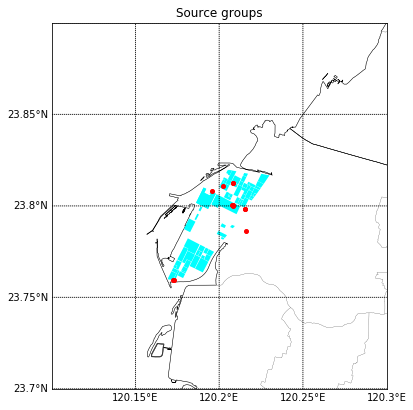

In [ ]:
dfiles='/archives/utils/SMOKE/data/inventory/teds9/point/CM*_ptinv_yulin_orl_nc.txt'
fig,ax=plt.subplots()
fig.set_figheight(8)
#fig.set_figwidth(10)
m=plottw([120.1,120.3,23.7,23.9])
plotboarders(m,ax)
m.drawmeridians(np.arange(100,180,.05),labels=[0,0,0,1],fontsize=10,ax=ax)
m.drawparallels(np.arange(0,40,.05),labels=[1,0,0,0],fontsize=10,ax=ax)
m.readshapefile('/archives/data/maps/yunlin/factories','factories',drawbounds=False)
patches=[]
for info, shape in zip(m.factories_info,m.factories):
    patches.append(Polygon(np.array(shape),True))        
ax.add_collection(PatchCollection(patches,facecolor='aqua',edgecolor='none',linewidths=0,zorder=2,label='Factories'))
for nf,filename in enumerate(glob.glob(dfiles)):
    df,cnm=read_inv(filename)
    stx=df['stx'].values.mean()
    sty=df['sty'].values.mean()
    stxi,styi=m(stx,sty)
    ax.plot(stxi,styi,'o',mfc='r',mec='r',markersize=4,label='Factories')
plt.title('Source groups')

## 2. Meteorology(WRFDA)
WRFDA模式重建之氣象場以驅動污染物傳輸。臺灣地區氣象與鄰近大氣環境密切相關，大尺度氣象現象如極地大陸性氣團，熱帶海洋性氣團，鋒面等對臺灣地區氣象皆有顯著的影響。地區氣象模式因此需加入大尺度氣象對其邊界條件的作用。WRFDA模擬範圍以雙向巣狀網格跨越中東經$90^\circ$至東經$145^\circ$及赤道$0^\circ$至北緯$40^\circ$加入綜觀(synoptic)尺度及中(meso)尺度氣象以產生合理的臺灣地區邊界。  
其他設定參照環保署模式支援中心報告（TWEPA，2017）所指出雲嘉地區最佳模式設定為GMTED2010（Global Multi-resolution Terrain Elevation Data 2010）地形資料、WSM5（Single Moment 5-class scheme）微物理參數、YSU（Yonsei University scheme）邊界層參數。
另以此模式設定加入海溫（NCEP FNL，2000）及數據同化（Data Assimilation）全球探空及地面測站資料（NCEP ADP，2008）與衛星輻射（NCEP GADS，2009）

In [ ]:
scnm='yulin3w2'
dname=f'/archives/simon/wrf/{scnm}/'
ncs=glob.glob(dname+'WPS/geo_em.d*nc')
varnms=['XLAT_M','XLONG_M','LANDMASK']
ovars=[]
for ii,tfile in enumerate(ncs):
    #print(str(ii)+tfile)
    tlink=netcdf.netcdf_file(tfile,'r')
    for jj,tvar in enumerate(varnms):
        #print(str(jj)+tvar)
        ovars.append(tlink.variables[tvar][:].copy())

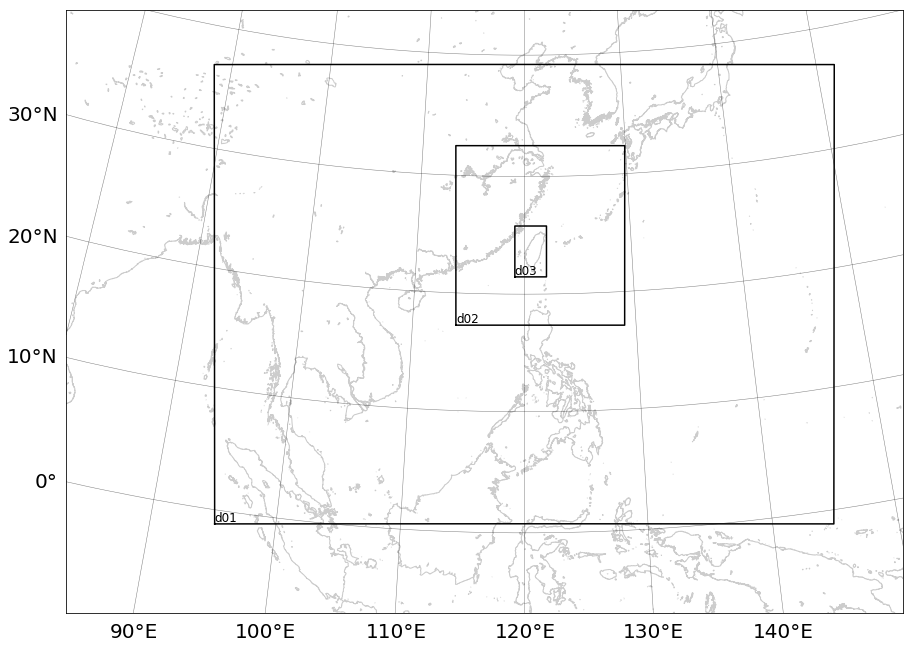

In [ ]:
fig=plt.figure(figsize=(15,15))
ax=plt.subplot(1,1,1)
m=Basemap(projection='lcc',llcrnrlon=85,urcrnrlon=160,llcrnrlat=-10,urcrnrlat=40,resolution='f',lat_0=20.,lon_0=120.,lat_ts=20.,ax=ax)
m.drawcoastlines(color=[0.8,0.8,0.8])
m.drawmeridians(np.arange(60,200,10),labels=[0,0,0,1],linewidth=0.5,fontsize=20)
m.drawparallels(np.arange(0,70,10),labels=[1,0,0,0],linewidth=0.5,fontsize=20)
for ii,tfile in enumerate(ncs):
    x1=np.concatenate((ovars[1+ii*3][0,0,:],ovars[1+ii*3][0,:,-1],ovars[1+ii*3][0,-1,:][::-1],ovars[1+ii*3][0,:,0][::-1]),axis=0)
    y1=np.concatenate((ovars[0+ii*3][0,0,:],ovars[0+ii*3][0,:,-1],ovars[0+ii*3][0,-1,:][::-1],ovars[0+ii*3][0,:,0][::-1]),axis=0)
    x1,y1=m(x1,y1)
    ax.plot(x1,y1,'k')
    ax.text(x1[0],y1[0],tfile[-6:-3],va='bottom',fontsize=12)
#fig.savefig('wrf_domains.png',rasterized=True,format='png',bbox_inches='tight',pad_inches=0.1,dpi=600) 

In [2]:
grdnm='YULIN2A'
emscen=''.join(['teds_',grdnm])
spcnm='BENZENE'
fname=f'/archives/simon/cmaq_ddm-3d/{grdnm}/data/mcip/METCRO3D_2014001.nc'
tlink=netcdf.netcdf_file(fname,'r')
zf=tlink.variables['ZF'][:].copy()
(nt,nz,ny,nx)=zf.shape

In [3]:
ddir1=''.join(['/archives/simon/cmaq_ddm-3d/',grdnm,'/data/'])
dfile1=glob.glob(''.join([ddir1,'emis/egts_l.*',emscen,'.ncf']))[0]
#dfile1=''.join([ddir1,'emis/egts_l.20140101.14.',emscen,'.ncf'])
tin,vout,dx,dx0c,xc,dy,dy0c,yc,nt,nz,ny,nx=read_cmaq(dfile1,[spcnm])
m,xs,ys=cmaq_map(dx,dx0c,xc,dy,dy0c,yc,nt,nz,ny,nx,res='f')
xr,yr=m([119.5,121],[23.2,24.2])
xtk=np.arange(119.,121.,.5)
ytk=np.arange(23.,25,.5)
xtk1,ytk1=m(xtk,ytk)
m.urcrnrx=xr[1];m.urcrnry=yr[1];m.llcrnrx=xr[0];m.llcrnry=yr[0]
xs1=np.tile(np.expand_dims(xs,axis=0),(len(ys),1))
ys1=np.tile(np.expand_dims(ys,axis=1),(1,len(xs)))

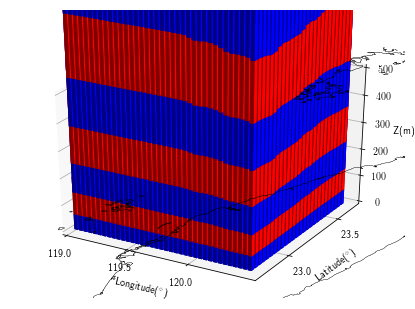

In [13]:
#Z level at t=0
xind=np.where((xs>xr[0])&(xs<xr[1]))[0]
yind=np.where((ys>yr[0])&(ys<yr[1]))[0]
z0=np.zeros(xs1.shape)[yind.min():yind.max(),xind.min():xind.max()]
plt.rc('text', usetex=True)
fig=plt.figure()
ax=Axes3D(fig)
#polys = []
#for shape in m.landpolygons:
#    polys.append(shape.get_coords())         
#ax.add_collection3d(PolyCollection(polys,edgecolor='black',facecolor='#DDDDDD',zorder=1))
dbar=3000
for i in range(7):
    zb=z0.ravel()
    z1=zf[0,i,yind.min():yind.max(),xind.min():xind.max()].ravel()
    if i > 0:
        zb=zf[0,i-1,yind.min():yind.max(),xind.min():xind.max()].ravel()+zb
    cl='b'    
    if np.mod(i,2)==1:
        cl='r'
    ax.bar3d(xs1[yind.min():yind.max(),xind.min():xind.max()].ravel(),ys1[yind.min():yind.max(),xind.min():xind.max()].ravel(),zb,z0.ravel()+dbar,z0.ravel()+dbar,z1,color=cl,alpha=0.9,zorder=2)
ax.add_collection3d(m.drawcoastlines(linewidth=0.25))
ax.add_collection3d(m.drawcountries(linewidth=0.35))
ax.set_zlim(0,500)
ax.set_zlabel('Z(m)')
ax.set_ylabel('Latitude($^\circ$)')
ax.set_xlabel('Longitude($^\circ$)')
ax.xaxis.set_major_locator(ticker.FixedLocator(xtk1))
ax.yaxis.set_major_locator(ticker.FixedLocator(ytk1))
ax.set_xticklabels(xtk)
ax.set_yticklabels(ytk)

### 2.1 Ground station(NCEP ADP, 2008) used by WRFDA

In [ ]:
#WRFDA plot pending

### 2.2 Performance

In [ ]:
#WRFDA plot pending

## CMAQ_DDM_3D(USEPA, 2017)
### 1. Addition of new species to CMAQ
  - Henry's law gas-liquid phase partitioning for each new species where $H^{cp}$ is the Henry solubility. $c_a$ is concentration in aqueous phase and $p$ is partial pressure in the gas phase under equilibrium.
  $$H^{cp}=\frac{c_a}{p}$$
  Modification added to CMAQ_DDM-3D/CCTM/src/cloud/acm_ae6_mp/hlconst.F according to the list compiled by Sander(2015).  
  - No reaction definition added so far
  "CMAQ_DDM-3D/CCTM/src/MECHS/cb6r3_ae6yulintox/CSQY_DATA_cb6r3_ae6yulintox.nml"  
  - No Photolysis Rate Parameters added "CMAQ_DDM-3D/CCTM/src/MECHS/cb6r3_ae6yulintox/CSQY_DATA_cb6r3_ae6yulintox.nml"  
  
### 2. Sensitivity of model concentration from each source groups.
##### a. Sensitivity configuration
  - Full domain grid point concentration sensitivity matrix to grid point emission.
  - Partial domain grid point concentration sensitivity matrix to each of the 12 Yunlin source groups.
  - Partial domain grid point concentration sensitivity matrix to the boundary condition.
  
##### b. Model calibration

# References

 
1. National Centers for Environmental Prediction/National Weather Service/NOAA/U.S. Department of Commerce. (2000) updated daily. NCEP FNL Operational Model Global Tropospheric Analyses, continuing from July 1999. Research Data Archive at the National Center for Atmospheric Research, Computational and Information Systems Laboratory. https://doi.org/10.5065/D6M043C6. Accessed 20171111.  

1. National Centers for Environmental Prediction/National Weather Service/NOAA/U.S. Department of Commerce. (2008) updated daily. NCEP ADP Global Upper Air and Surface Weather Observations (PREPBUFR format), May 1997 - Continuing. Research Data Archive at the National Center for Atmospheric Research, Computational and Information Systems Laboratory. http://rda.ucar.edu/datasets/ds337.0/. Accessed 20171113.  

1. National Centers for Environmental Prediction/National Weather Service/NOAA/U.S. Department of Commerce. (2009) updated daily. NCEP GDAS Satellite Data 2004-continuing. Research Data Archive at the National Center for Atmospheric Research, Computational and Information Systems Laboratory. http://rda.ucar.edu/datasets/ds735.0/. Accessed 20171129.  

1. Sander, R. (2015). Compilation of Henry's law constants (version 4.0) for water as solvent. Atmos. Chem. Phys., 15:4399-V4981, 2015

1. USEPA (2014) National Air Toxics Assessment. U.S. Environmental Protection Agency, Office of Air and Radiation, Office of Air Quality Planning and Standards, Air Quality Assessment Division https://www.epa.gov/air-emissions-modeling/2014-version-70-platform  

1. USEPA (2017) CMAQ Decoupled Direct Method in Three Dimensions (CMAQ-DDM-3D). https://www.epa.gov/cmaq/cmaq-decoupled-direct-method-three-dimensions-cmaq-ddm-3d. Accessed 20171211  

1. TWEPA (2013) Taiwan Emission Data System 9.0(TEDS9.0). Taiwan Environmental Protection Administration, https://teds.epa.gov.tw 

1. TWEPA (2017) 強化空氣品質模式制度建立計畫(第二年). 行政院環境保護署. EPA-105 -FA18FA18 -03 -D045 期末報告定稿